In [ ]:
# 從kaggle下載oxford-pets圖片資料集
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download alexisbcook/oxford-pets/ --unzip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/alexisbcook/oxford-pets/versions/
License(s): unknown
 98% 762M/780M [00:17<00:00, 84.0MB/s]
100% 780M/780M [00:17<00:00, 47.1MB/s]


In [ ]:
#引入必要函式
import os
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers

In [ ]:
#讀取圖片檔案
input_dir = '/content/images/images'
target_dir = '/content/annotations/annotations/trimaps'
img_size = (160, 160)
num_classes = 3
batch_size = 16

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

Number of samples: 7390


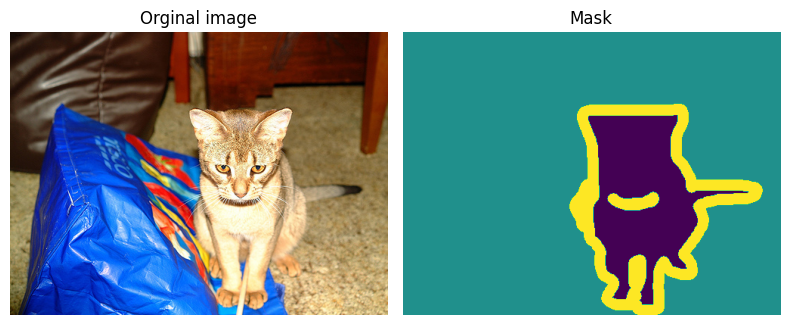

In [ ]:
#印出圖片並看遮罩
i = 7
figure, ax = plt.subplots(nrows=1,ncols=2,figsize=(8,8))
ax.ravel()[0].imshow(mpimg.imread(input_img_paths[i]))
ax.ravel()[0].set_title("Orginal image")
ax.ravel()[0].set_axis_off()
ax.ravel()[1].imshow(mpimg.imread(target_img_paths[i]))
ax.ravel()[1].set_title("Mask")
ax.ravel()[1].set_axis_off()
#ax.ravel()[2].imshow(PIL.ImageOps.autocontrast(load_img(target_img_paths[i])))
#ax.ravel()[2].set_title("Contrast of mask")
#ax.ravel()[2].set_axis_off()
plt.tight_layout()

In [ ]:
#定義寵物Dataset
class PetsDataset(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

In [ ]:
#自定義一個model
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 80, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 80, 80, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 80, 80, 32)           0         ['batch_normalization[0][0

In [ ]:
#分割訓練與驗證集
val_samples = 1108 # 85% Training -- 15% Validation
random.Random(1822).shuffle(input_img_paths)
random.Random(1822).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = PetsDataset(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = PetsDataset(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [ ]:
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("pets_segmentation.h5", save_best_only=True)
]

epochs = 30
modelunet=model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/30
392/392 [==============================] - ETA: 0s - loss: 0.8324 - accuracy: 0.3107

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


392/392 [==============================] - 1917s 5s/step - loss: 0.8324 - accuracy: 0.3107 - val_loss: 2.2878 - val_accuracy: 0.0000e+00
Epoch 2/30
392/392 [==============================] - 1829s 5s/step - loss: 0.4652 - accuracy: 0.3121 - val_loss: 0.4234 - val_accuracy: 0.3093
Epoch 3/30
392/392 [==============================] - 1774s 5s/step - loss: 0.4055 - accuracy: 0.3117 - val_loss: 0.4770 - val_accuracy: 0.2433
Epoch 4/30
387/392 [============================>.] - ETA: 21s - loss: 0.3675 - accuracy: 0.3108

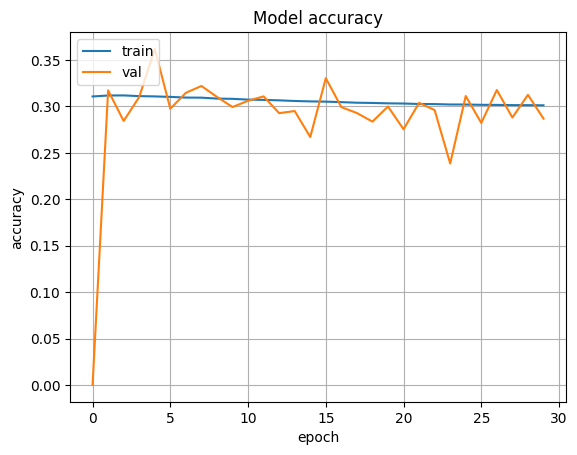

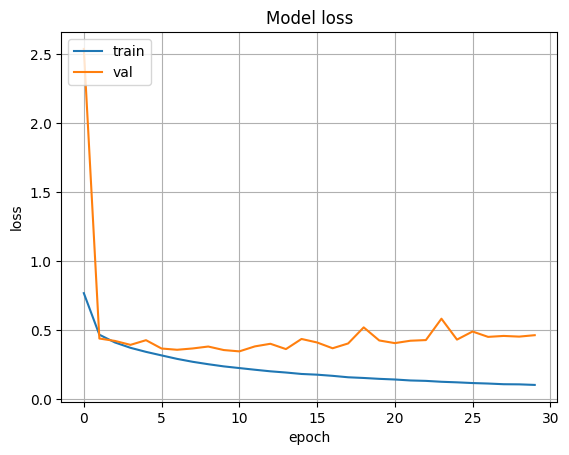

In [ ]:
# summarize history for accuracy
plt.plot(modelunet.history['accuracy'])
plt.plot(modelunet.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()
# summarize history for loss
plt.plot(modelunet.history['loss'])
plt.plot(modelunet.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
# Generate predictions for all images in the validation set
val_gen = PetsDataset(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

69/69 [==============================] - 5s 61ms/step


In [ ]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    return img

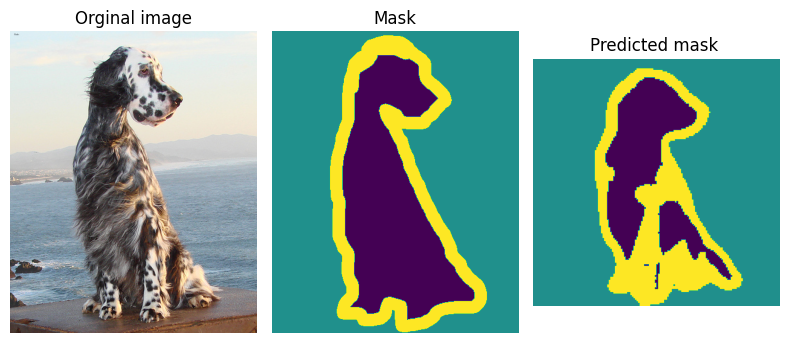

In [ ]:
# Display image #120
i = 120
figure, ax = plt.subplots(nrows=1,ncols=3,figsize=(8,5))
ax.ravel()[0].imshow(mpimg.imread(val_input_img_paths[i]))
ax.ravel()[0].set_title("Orginal image")
ax.ravel()[0].set_axis_off()
ax.ravel()[1].imshow(mpimg.imread(val_target_img_paths[i]))
ax.ravel()[1].set_title("Mask")
ax.ravel()[1].set_axis_off()
ax.ravel()[2].imshow(display_mask(i))
ax.ravel()[2].set_title("Predicted mask ")
ax.ravel()[2].set_axis_off()
plt.tight_layout()